In [1]:
import torch
import util
import custum_dataset
from torch.utils.data import DataLoader
from model import Model,save_model
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt


# 1.setting up

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = f'C:/Users/yy/Desktop/dl_project/data/data.txt'  

c = util.config()

data_train,stoi,itos = util.load_data_with_split(path,c.split,type='train')
data_test,_,_ = util.load_data_with_split(path,c.split,type='test')


dataset_train = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_train,repeat = False)
data_loader_train = DataLoader(dataset_train, c.batch_size, shuffle=True)
dataset_test = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_test,repeat = False)
data_loader_test = DataLoader(dataset_test, c.batch_size, shuffle=True)

m = Model(stoi=dataset_train.stoi).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=c.learning_rate)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=5)
nb_epoch = 4000

milestones = np.arange(0,nb_epoch,50)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, 0.1)
MODEL_NAME = str(nb_epoch)+"epoch_model.pth"

# 2. train and evaluate

In [3]:
train_data_iterator = iter(data_loader_train)
test_data_iterator = iter(data_loader_test)
train_loss_list = []
test_loss_list = []
perplexity_train_list = []
perplexity_test_list = []

for epoch in range(nb_epoch):
    m.train()
    x,y = next(train_data_iterator)
    logit, loss, perplexity = m(x,use='train',y = y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    m.eval()
    with torch.inference_mode():
        x_t,y_t = next(test_data_iterator)
        test_logit, test_loss, test_perplexity = m(x_t, use='train', y=y_t)

    if epoch%50 == 0:
        print(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Perplexity: {test_perplexity:.4f}")

#    scheduler.step()
    train_loss_list.append(loss.cpu().detach().numpy())
    test_loss_list.append(test_loss.cpu().detach().numpy())
    perplexity_train_list.append(perplexity.cpu().detach().numpy())
    perplexity_test_list.append(test_perplexity.cpu().detach().numpy())

save_model(m, MODEL_NAME)


Epoch 1/4000, Loss: 4.3482, Perplexity: 77.3417
Test Loss: 3.5892, Test Perplexity: 36.2067
Epoch 51/4000, Loss: 2.5828, Perplexity: 13.2342
Test Loss: 2.5687, Test Perplexity: 13.0489
Epoch 101/4000, Loss: 2.4805, Perplexity: 11.9474
Test Loss: 2.5097, Test Perplexity: 12.3016
Epoch 151/4000, Loss: 2.4526, Perplexity: 11.6184
Test Loss: 2.4638, Test Perplexity: 11.7492
Epoch 201/4000, Loss: 2.4127, Perplexity: 11.1643
Test Loss: 2.4459, Test Perplexity: 11.5404
Epoch 251/4000, Loss: 2.3784, Perplexity: 10.7871
Test Loss: 2.3983, Test Perplexity: 11.0047
Epoch 301/4000, Loss: 2.2949, Perplexity: 9.9238
Test Loss: 2.3280, Test Perplexity: 10.2573
Epoch 351/4000, Loss: 2.2081, Perplexity: 9.0985
Test Loss: 2.2535, Test Perplexity: 9.5209
Epoch 401/4000, Loss: 2.1108, Perplexity: 8.2550
Test Loss: 2.1951, Test Perplexity: 8.9806
Epoch 451/4000, Loss: 2.0396, Perplexity: 7.6879
Test Loss: 2.1296, Test Perplexity: 8.4113
Epoch 501/4000, Loss: 2.0318, Perplexity: 7.6280
Test Loss: 2.0590, Te

# 3. Plot loss and perplexity 

Text(0, 0.5, 'perplexity')

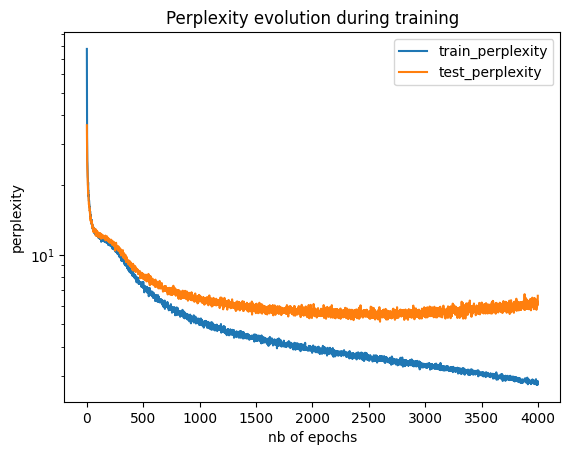

In [4]:
epoch_list = np.arange(0,len(perplexity_train_list))
plt.plot(epoch_list,perplexity_train_list)
plt.plot(epoch_list,perplexity_test_list)
plt.yscale("log")
plt.title('Perplexity evolution during training')
plt.legend(['train_perplexity','test_perplexity'])
plt.xlabel('nb of epochs')
plt.ylabel('perplexity')

Text(0, 0.5, 'cross entropy loss')

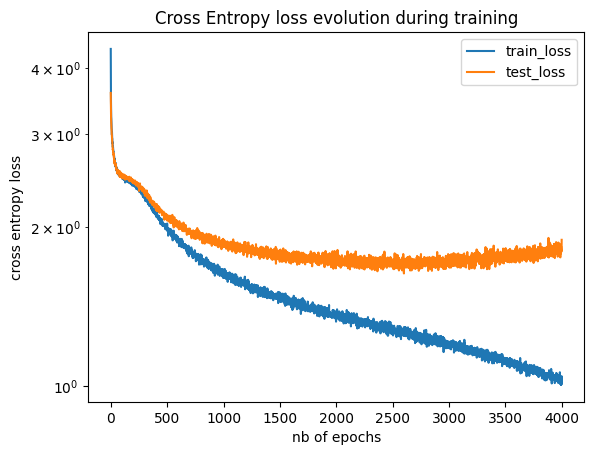

In [5]:
epoch_list = np.arange(0,len(train_loss_list))
plt.plot(epoch_list,train_loss_list)
plt.plot(epoch_list,test_loss_list)
plt.yscale("log")
plt.title('Cross Entropy loss evolution during training')
plt.legend(['train_loss','test_loss'])
plt.xlabel('nb of epochs')
plt.ylabel('cross entropy loss')



In [6]:
nb_char = 3000

seed = "I saw a cat jumping onto the table, "
input_idx = util.encode(seed,stoi)

input_idx = torch.tensor(input_idx,dtype=torch.long)
input_idx = torch.unsqueeze(input_idx, 0).to(device)


In [7]:
m.eval()
with torch.no_grad():
    out = m.generate(nb_char,input_idx,'sample')
    out = util.decode(out,itos)
    

util.save_generated_text('output'+str(nb_epoch)+'_epochs_sample.txt',out)

In [8]:
m.eval()
with torch.no_grad():
    out = m.generate(nb_char,input_idx,'high_prob')
    out = util.decode(out,itos)
util.save_generated_text('output'+str(nb_epoch)+'epochs_high_prob.txt',out)


